# PyTorch Iterable Datasetand DataLoaders

> see [How to Build a Streaming DataLoader with PyTorch](https://medium.com/speechmatics/how-to-build-a-streaming-dataloader-with-pytorch-a66dd891d9dd)

> see [How to use Pytorch Dataloaders to work with enormously large text files](https://medium.com/swlh/how-to-use-pytorch-dataloaders-to-work-with-enormously-large-text-files-bbd672e955a0)

PyTorch Datasets are objects that have a single job: to return a single datapoint on request. The exact form of the datapoint varies between tasks: it could be a single image, a slice of a time series, a tabular record or something else entirely. These are then passed on to a Dataloader which handles batching of datapoints and parallelism.

Before PyTorch 1.2 the only available dataset class was the original `“map-style”` dataset. This simply requires the user to inherit from the torch.utils.data.Dataset class and implement the `__len__` and `__getitem__` methods, where `__getitem__` receives an index which is mapped to some item in your dataset. Let’s see a very simple example.

In [1]:
import torch.utils.data as data
class MyMapDataset(data.Dataset): 
    def __init__(self, data):
        self.data = data
    def __getitem__(self, index):
        return self.data[index]

    def __len__(self):
        return len(self.data)

This is instantiated and passed to the DataLoader, which is iterated over, returning batches of data to feed into our model.

In [2]:
from itertools import islice
from torch.utils.data import DataLoader
my_data = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
map_dataset = MyMapDataset(my_data)
loader = DataLoader(map_dataset, batch_size = 4)

for batch in loader:
    print(batch)

tensor([0, 1, 2, 3])
tensor([4, 5, 6, 7])
tensor([ 8,  9, 10, 11])


This remains a flexible abstraction, however, the `assumption` that you can trivially map each data point in your dataset means that it is less suited to situations where the input data is arriving as part of a stream, for example, an audio or video feed. Alternatively, each datapoint might be a subset of a file which is too large to be held in memory and so requires incremental loading during training. These situations can be addressed with more complex logic in our dataset or additional pre-processing of our inputs, but there is now a more natural solution, enter the `IterableDataset`!

In [3]:
import torch.utils.data as data
class MyIterableDataset(data.IterableDataset): 
    def __init__(self, data):
        self.data = data
    def __iter__(self):
        return iter(self.data)
    
iterable_dataset = MyIterableDataset(my_data)
loader = DataLoader(iterable_dataset, batch_size = 4)

for batch in loader:
    print(batch)

tensor([0, 1, 2, 3])
tensor([4, 5, 6, 7])
tensor([ 8,  9, 10, 11])


For both examples, we are returning the same result. So, what is the practical difference between these objects?

- At a high level, each time the DataLoader returns a batch from the “map-style” dataset, it is sampling a set of indices and retrieving them with `map_dataset[idx]`. 

- In contrast, for the `IterableDataset` the DataLoader is calling `next(iterable_dataset)` until it has built a full batch. One use-case where this latter approach excels is feeding data to a sequential model. A more concrete example is shown below.

In [4]:
from itertools import cycle, islice
import torch.utils.data as data
from torch.utils.data import DataLoader

class MyIterableDatasetV2(data.IterableDataset): 
    def __init__(self, data_path, file_list_txt):
        super(MyIterableDatasetV2, self).__init__()
        self.file_list_txt = file_list_txt
        self.data_path = data_path
        f = open(self.file_list_txt, 'r')
        self.file_list = [l.rstrip() for l in f.readlines()]
        print ("[***] img# = {}, file_list = {}, ..., {}".format(len(self.file_list), 
            self.file_list[0], self.file_list[len(self.file_list) - 1]))
    
    def parse_file(self):
        f = open(self.file_list_txt, 'r')
        for l in f.readlines():
            yield from l.rstrip()
    def get_stream(self):
        #return cycle(self.parse_file())
        return iter(self.parse_file())
        
    def __iter__(self):
        return self.get_stream()
    
data_path = '/media/ccjData2/datasets/SceneFlowDataset/'
file_txt = '/home/ccj/atten-stereo/lists/sceneflow_train_small.list'
iterable_dataset = MyIterableDatasetV2(data_path, file_txt)
loader = DataLoader(iterable_dataset, batch_size = 50)

for batch in islice(loader, 3):
    print(batch)
    
#for batch in loader:
#    print(batch)

[***] img# = 50, file_list = driving/frames_finalpass/15mm_focallength/scene_backwards/slow/left/0419.png, ..., driving/frames_finalpass/15mm_focallength/scene_backwards/slow/left/0134.png
['d', 'r', 'i', 'v', 'i', 'n', 'g', '/', 'f', 'r', 'a', 'm', 'e', 's', '_', 'f', 'i', 'n', 'a', 'l', 'p', 'a', 's', 's', '/', '1', '5', 'm', 'm', '_', 'f', 'o', 'c', 'a', 'l', 'l', 'e', 'n', 'g', 't', 'h', '/', 's', 'c', 'e', 'n', 'e', '_', 'b', 'a']
['c', 'k', 'w', 'a', 'r', 'd', 's', '/', 's', 'l', 'o', 'w', '/', 'l', 'e', 'f', 't', '/', '0', '4', '1', '9', '.', 'p', 'n', 'g', 'm', 'o', 'n', 'k', 'a', 'a', '/', 'f', 'r', 'a', 'm', 'e', 's', '_', 'f', 'i', 'n', 'a', 'l', 'p', 'a', 's', 's', '/']
['f', 'u', 'n', 'n', 'y', 'w', 'o', 'r', 'l', 'd', '_', 'a', 'u', 'g', 'm', 'e', 'n', 't', 'e', 'd', '0', '_', 'x', '2', '/', 'l', 'e', 'f', 't', '/', '0', '3', '5', '8', '.', 'p', 'n', 'g', 'm', 'o', 'n', 'k', 'a', 'a', '/', 'f', 'r', 'a', 'm', 'e']


At each step of our very basic iterator, we are returning a single token from our dataset, which the `DataLoader` then aggregates into batches (each row of the output is a batch). We are using `itertools.cycle` here to create an infinite iterator, so when we reach the end of an epoch we loop back around to the start. This guarantees consistent batch sizes and avoids having to implement any file-end logic. Note that this example shows only a very short piece of text to illustrate the cycle in action. In practice, you would also want your dataset to return encoded indices instead of raw tokens.

Hopefully, it should now be clear in which scenarios the `IterableDataset` is useful. For the next set of examples, we return to using a numeric dataset with trivial parsing logic as this makes it easier to illustrate key points. Here is the previous example re-implemented.

In [5]:
import torch.utils.data as data

class MyIterableDatasetV3(data.IterableDataset): 
    def __init__(self, data):
        self.data = data
    def process_data(self):
        for x in self.data:
            yield x

    def get_stream(self):
        #return cycle(self.process_data())
        return self.process_data()
        
    def __iter__(self):
        return self.get_stream()

my_data = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
iterable_dataset2 = MyIterableDatasetV3(my_data)
loader = data.DataLoader(iterable_dataset2, batch_size = 4)

#for batch in islice(loader, 8):
#    print(batch)
for epo in range(0, 3):
    print ("epo # = %d" % epo)
    for batch in loader:
        print(batch)

epo # = 0
tensor([0, 1, 2, 3])
tensor([4, 5, 6, 7])
tensor([ 8,  9, 10, 11])
epo # = 1
tensor([0, 1, 2, 3])
tensor([4, 5, 6, 7])
tensor([ 8,  9, 10, 11])
epo # = 2
tensor([0, 1, 2, 3])
tensor([4, 5, 6, 7])
tensor([ 8,  9, 10, 11])


This example assumes that our entire input is contained within a single file, but we can easily extend our dataset to include multiple files of potentially inconsistent length by passing in a list of data sources and chaining them together.

## Utility Function

Here is a utility function to draw the timings, adopted from the orignal code at [here](https://gist.github.com/david-macleod/2b933d28fd3ac09766785728ee191f09), shown below:

In [6]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import time
import torch
import numpy as np

# added by CCJ;
def count(start=0, step=1):
    # count(10) --> 10 11 12 13 14 ...
    # count(2.5, 0.5) -> 2.5 3.0 3.5 ...
    n = start
    while True:
        yield n
        n += step

#> see:https://gist.github.com/david-macleod/2b933d28fd3ac09766785728ee191f09
def plot_timings(loader, n_batches, model_time=0.2, max_time=2.5):
    
    fig, ax = plt.subplots()
    ax.set_axisbelow(True)
    ax.yaxis.grid(which="major", color='black', linewidth=1)
    
    zero_time = time.time()
    
    worker_ids = {}
    worker_count = count() # added by CCJ;
    for result in islice(loader, n_batches):
        start = time.time()
        time.sleep(model_time)
        end = time.time()
                
        # check if already batched
        if isinstance(result[0], torch.Tensor):
            result = zip(*result)
            
        batch = []
        #print ('result = ', result)
        for item in result:
            data, worker, t1, t2 = tuple(map(scalar, item))
            #print ("processing worker id = %d"% worker )
            # fix worker position in plot
            if worker != -1:
                if worker not in worker_ids:
                    worker_ids[worker] = next(worker_count)
                worker = worker_ids[worker]
   
            plot_time_box(data, worker, t1-zero_time, t2-zero_time, ax)
            batch.append(data)
        
        batch_str = ",".join(map(str, batch))
        plot_time_box(batch_str, -1, start-zero_time, end-zero_time, ax, color='firebrick')
    
    max_worker = len(worker_ids) - 1 
        
    ax.set_xlim(0, max_time)
    ax.set_ylim(-1.5, max_worker + 0.5)
    ax.set_xticks(np.arange(0, max_time, 0.2))
    ax.set_yticks(np.arange(-1, max_worker+1, 1))
    ax.set_yticklabels([])
    ax.tick_params(axis='y', colors=(0,0,0,0))
    
    fig.set_figwidth(16)
    fig.set_figheight((max_worker + 2) * 0.5)
    
    ax.xaxis.label.set_color('gray')
    ax.tick_params(axis='x', colors='gray')
    for spine in ax.spines.values():
        spine.set_edgecolor((0,0,0,0))
        
def scalar(x):
    return x.item() if hasattr(x, 'item') else x

def plot_time_box(data, worker, t1, t2, ax, color='steelblue'):
    x = t1
    y = worker - 0.25
    w = t2 - t1
    h = 0.6
    
    rect = Rectangle((x, y), w, h, linewidth=2, edgecolor='black',facecolor=color)
    
    ax.add_patch(rect)
    
    ax.text(x + (w * 0.5), y + (h * 0.5), str(data), va='center', ha='center', color='white', weight='bold')  

## Going Parallel in Map-style Dataset

When training a model, the bottleneck for training speed can often be data loading, rather than the forward/backward pass through the model. There aren’t many benefits to using a GPU if it just spends most of its time sat around waiting for new data to arrive. We have already established that most use-cases for the `IterableDataset` rule out caching our entire dataset in memory, so we will instead look towards data loading in parallel as a potential solution for this.

The good news is that Pytorch makes parallel data loading very easy. All you have to do is increase `num_workers` on your DataLoader object! The not so good news is that there are some caveats which must be considered when calling an `IterableDataset` in parallel to ensure that the data you return is what you are expecting.

To explore this let’s go back to basics and revisit a simple map-style `Dataset` and `IterableDataset`, ignoring our earlier modifications for creating sequential streams. Rather than returning our data points, our datasets now time how long it takes to load each data point, as well as returning the id of the parallel worker that executed the task. We have inserted a constant delay into each dataset call to simulate loading a data point. We then plot a timeline which also includes a simulated pass through our model to illustrate the requirement for parallel loading.

Here are the timelines for loading our map-style dataset with zero, one and two workers.

In [7]:
import torch.utils.data as data
class MyMapDataset(data.Dataset): 
    def __init__(self, data):
        self.data = data
    def __getitem__(self, index):
        worker = torch.utils.data.get_worker_info()
        worker_id = worker.id if worker is not None else -1
        start = time.time()
        time.sleep(0.1)
        end = time.time()
        return self.data[index], worker_id, start, end

    def __len__(self):
        return len(self.data)
    
my_data = range(0, 17)
map_dataset = MyMapDataset(my_data)
my_batch_size = 4

[***] map-style dataset with 0 workers


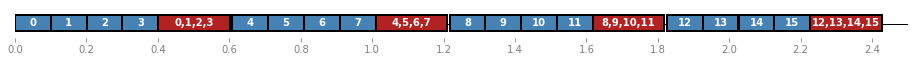

In [8]:
my_num_workers = 0
print ('[***] map-style dataset with %d workers' % my_num_workers)
loader = DataLoader(map_dataset, batch_size = my_batch_size, num_workers = my_num_workers)
plot_timings(loader, model_time=0.2, n_batches=my_batch_size)

[***] map-style dataset with 1 workers


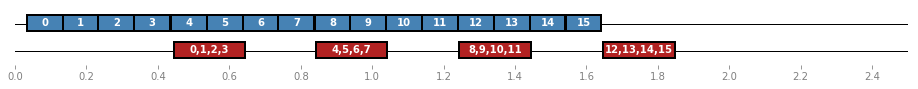

In [9]:
my_num_workers = 1
print ('[***] map-style dataset with %d workers' % my_num_workers)
loader = DataLoader(map_dataset, batch_size = my_batch_size, num_workers = my_num_workers)
plot_timings(loader, model_time=0.2, n_batches=my_batch_size)

[***] map-style dataset with 2 workers


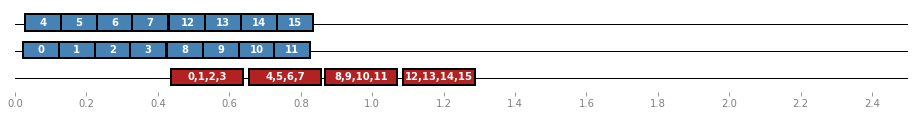

In [10]:
my_num_workers = 2
print ('[***] map-style dataset with %d workers' % my_num_workers)
loader = DataLoader(map_dataset, batch_size = my_batch_size, num_workers = my_num_workers)
plot_timings(loader, model_time=0.2, n_batches=my_batch_size)

The bottom row in each timeline represents the main Python process. Every other row shows a single subprocess (`parallel worker`). The red boxes show timings for the model forward/backwards pass while the blue boxes show timings for loading a single datapoint. Numbers inside boxes show the datapoint that was loaded, or in the case of the model, the datapoints that contributed to that batch.

We can see that with `num_workers=0`, the main process takes charge of both the model pass and the data loading. Execution is completely in series with the model pass having to finish before data loading can continue.

With `num_workers=1` we now have a separate process which is purely responsible for data loading. This allows us to start loading the next batch whilst the current batch is processed through the model. Note also that there is a slight delay at the start of processing due to the setup time incurred by the worker.

With one worker the model still has waiting time, but this is solved by `setting num_workers=2`. This guarantees that we have enough data loaded and waiting each time the model is ready to receive a batch. Once this state has been achieved, there is no real benefit to further increase the number of workers. In any case, PyTorch will only pre-fetch up to two batches per worker. Once the data queue is saturated the workers will now be in a situation where they are waiting.

## Going Parallel in IterableDataset

We will now replicate these results this time using the IterableDataset.

[***] map-style dataset with 0 workers


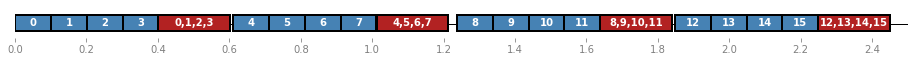

In [11]:
import torch.utils.data as data

class MyIterableDatasetV4(data.IterableDataset): 
    def __init__(self, data):
        self.data = data
    def __iter__(self):
        for x in self.data:
            worker = data.get_worker_info()
            worker_id = worker.id if worker is not None else -1
            
            start = time.time()
            time.sleep(0.1)
            end = time.time()
            
            yield x, worker_id, start, end

my_data = range(0, 17)
iterable_dataset = MyIterableDatasetV4(my_data)
my_batch_size = 4

my_num_workers = 0
print ('[***] map-style dataset with %d workers' % my_num_workers)
loader = DataLoader(iterable_dataset, batch_size = my_batch_size, num_workers = my_num_workers)
plot_timings(loader, model_time=0.2, n_batches=my_batch_size)

[***] map-style dataset with 1 workers


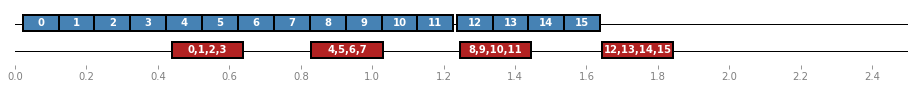

In [12]:
my_num_workers = 1
print ('[***] map-style dataset with %d workers' % my_num_workers)
loader = DataLoader(iterable_dataset, batch_size = my_batch_size, num_workers = my_num_workers)
plot_timings(loader, model_time=0.2, n_batches=my_batch_size)

With zero or one worker, we get the same result as the map-style dataset but look at what happens when we use two workers.

[***] map-style dataset with 2 workers


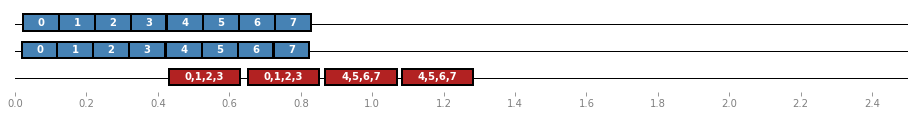

In [13]:
my_num_workers = 2
print ('[***] map-style dataset with %d workers' % my_num_workers)
loader = DataLoader(iterable_dataset, batch_size = my_batch_size, num_workers = my_num_workers)
plot_timings(loader, model_time=0.2, n_batches=my_batch_size)

### Using worker_init_fn to avoid duplicate data loading

We are now returning `duplicate data` across our batches! The reason for this is that: 
> when each worker is initialised it receives a copy of the dataset. In the case of the map-style dataset, this is not an issue as the object is stateless and the data to be retrieved is defined by `index` samples sent to each worker. 

However, when using `IterableDataset` each worker iterates over its own separate object which results in a duplicated output. This issue is highlighted in the PyTorch docs and the proposed solution is to add a `worker_init_fn` telling each worker to only process a subset of the data.

We can see a simple example below which divides our data across workers.

In [14]:
# Define a `worker_init_fn` that configures each dataset copy differently
def my_worker_init_fn(unsed_arg):
    worker_info = torch.utils.data.get_worker_info()
    cur_dataset = worker_info.dataset  # the dataset copy in this worker process
    worker_id = worker_info.id
    # configure the dataset to only process the split workload
    split_size = len(cur_dataset.data) // worker_info.num_workers
    #print ('split_size = ', split_size)
    cur_dataset.data = cur_dataset.data[worker_id*split_size : (worker_id + 1)*split_size]

[***] map-style dataset with 2 workers


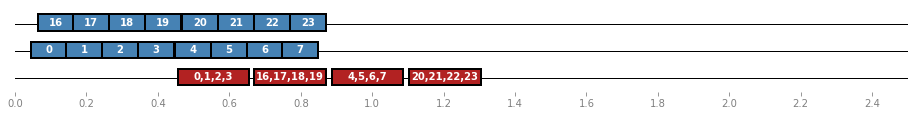

In [15]:
my_data2 = range(0, 32)
iterable_dataset2 = MyIterableDatasetV4(my_data2)
my_batch_size = 4

my_num_workers = 2
print ('[***] map-style dataset with %d workers' % my_num_workers)
loader = DataLoader(iterable_dataset2, batch_size = my_batch_size, num_workers = my_num_workers,
                   worker_init_fn = my_worker_init_fn)

plot_timings(loader, model_time=0.2, n_batches=my_batch_size)

[***] map-style dataset with 4 workers


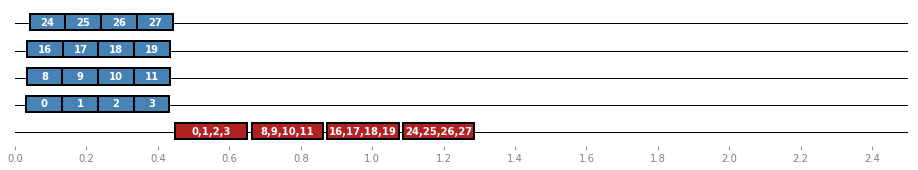

In [16]:
my_num_workers = 4
print ('[***] map-style dataset with %d workers' % my_num_workers)

loader = DataLoader(iterable_dataset2, batch_size = my_batch_size, num_workers = my_num_workers,
                   worker_init_fn = my_worker_init_fn)

plot_timings(loader, model_time=0.2, n_batches=my_batch_size)

Note the order in which the data is returned: workers alternate in returning a single, entire batch. PyTorch guarantees this `cyclic` behaviour and we can view the outstanding tasks directly by inspecting the `task_info` dictionary. Each key represents the `ordered` task id and its corresponding value is the worker which will carry out that task.

In [17]:
print ("-"*20)
print(iter(loader).task_info)

--------------------
{0: (0,), 1: (1,), 2: (2,), 3: (3,), 4: (0,), 5: (1,), 6: (2,), 7: (3,)}


Using this knowledge, we will now re-implement our “sequential” IterableDataset which we defined in the previous section and test that is it suitable for parallel execution.

In [18]:
import random
from itertools import chain, cycle
import torch.utils.data as data

class MyIterableDatasetV5(data.IterableDataset):
    def __init__(self, data_list, batch_size):
        self.data_list = data_list
        self.batch_size = batch_size
    
    @property
    def shuffled_data_list(self):
        return random.sample(self.data_list, len(self.data_list))
    
    def process_data(self, my_data):
        for x in my_data:
            worker = data.get_worker_info()
            worker_id = worker.id if worker is not None else -1
            
            start = time.time()
            time.sleep(0.1)
            end = time.time()
            
            yield x, worker_id, start, end
            
    def get_stream(self, data_list):
        return chain.from_iterable(map(self.process_data, cycle(data_list)))
    
    def get_streams(self):
        return zip(*[self.get_stream(self.shuffled_data_list) for _ in range(0, self.batch_size)])
    
    def __iter__(self):
        return self.get_streams()

--------------------


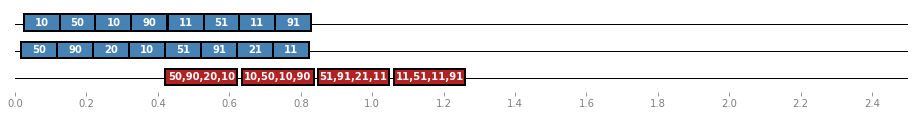

In [19]:
my_data_list = [[10, 11, 12, 13],
                [20, 21, 22, 23],
                [30, 31, 32, 33],
                [40, 41, 42, 43],
                [50, 51, 52, 53],
                [60, 61, 62, 63],
                [70, 71, 72, 73],
                [80, 81, 82, 83],
                [90, 91, 92, 93],
               ]

my_batch_size = 4
my_num_workers = 2
iterable_dataset = MyIterableDatasetV5(my_data_list, batch_size = my_batch_size)
loader = DataLoader(iterable_dataset, batch_size=None, num_workers=my_num_workers)
print ("-"*20)
#print(iter(loader).task_info)
plot_timings(loader, model_time=0.2, n_batches = my_batch_size)

Our shuffled streams have implicitly solved the issue of duplicate batches, as each worker now has its own random seed. However, this does not help our sequential model which requires that `consecutive` batches return contiguous items from each stream. We need each worker to be operating on the same streams but at a different `offset` so that the returned data is interleaved and in the correct order. One approach to this solution is to fix the random seed of our workers and slice our streams with an offset equal to the number of workers. We can implement this change by modifying the `__iter__` method of our class.

In [20]:
import random
from itertools import chain, cycle
import torch.utils.data as data

class MyIterableDatasetV6(data.IterableDataset):
    def __init__(self, data_list, batch_size):
        self.data_list = data_list
        self.batch_size = batch_size
    
    @property
    def shuffled_data_list(self):
        return random.sample(self.data_list, len(self.data_list))
    
    def process_data(self, my_data):
        for x in my_data:
            worker = data.get_worker_info()
            worker_id = worker.id if worker is not None else -1
            
            start = time.time()
            time.sleep(0.1)
            end = time.time()
            
            yield x, worker_id, start, end
            
    def get_stream(self, data_list):
        return chain.from_iterable(map(self.process_data, cycle(data_list)))
    
    def get_streams(self):
        return zip(*[self.get_stream(self.shuffled_data_list) for _ in range(0, self.batch_size)])
    
    def __iter__(self):
        worker_info = data.get_worker_info()
        cur_data = worker_info.dataset
        worker_id = worker_info.id
        n_workers = worker_info.num_workers
        random.seed(1234)
        return islice(self.get_streams(), worker_id, None, n_workers)

--------------------


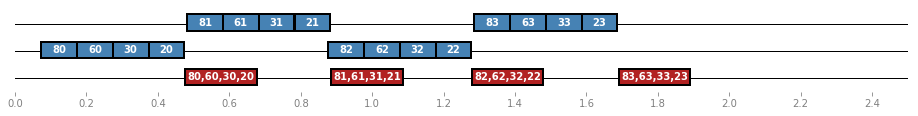

In [21]:
my_data_list = [[10, 11, 12, 13],
                [20, 21, 22, 23],
                [30, 31, 32, 33],
                [40, 41, 42, 43],
                [50, 51, 52, 53],
                [60, 61, 62, 63],
                [70, 71, 72, 73],
                [80, 81, 82, 83],
                [90, 91, 92, 93],
               ]

my_batch_size = 4
my_num_workers = 2
iterable_dataset = MyIterableDatasetV6(my_data_list, batch_size = my_batch_size)
loader = DataLoader(iterable_dataset, batch_size=None, num_workers=my_num_workers)
print ("-"*20)
#print(iter(loader).task_info)
plot_timings(loader, model_time=0.2, n_batches = my_batch_size)

This returns our data in the correct order, with each batch position a continuation of the same sequence from the previous batch. However, parallel performance is lost as `islice` still needs to process each item to increment the iterator for a given worker. In other words, each worker is processing the same data but just returning a subset of it. Herein lies the fundamental problem with `parallelism across batches` with a streaming input. What we actually require is parallelism within batches where each worker is responsible for loading a subset of a single batch.

## Parallelism Across Batches with a Streaming Input

As PyTorch assumes that each parallel worker is returning an entire batch we will have to write our own DataLoader to achieve parallelism within batches. Rather than start from scratch, we can utilise subprocess management and data `pre-fetching` by splitting our batch into subsets, passing each part to a separate PyTorch DataLoader, then zipping the results together.

In [31]:
class MyIterableDatasetV7(data.IterableDataset):
    def __init__(self, data_list, batch_size):
        self.data_list = data_list
        self.batch_size = batch_size
    
    @property
    def shuffled_data_list(self):
        return random.sample(self.data_list, len(self.data_list))
    
    def process_data(self, mydata):
        for x in mydata:
            worker = torch.utils.data.get_worker_info()
            worker_id = id(self) if worker is not None else -1
            
            start = time.time()
            time.sleep(0.1)
            end = time.time()
            
            yield x, worker_id, start, end
            
    def get_stream(self, data_list):
        return chain.from_iterable(map(self.process_data, cycle(data_list)))
    
    def get_streams(self):
        return zip(*[self.get_stream(self.shuffled_data_list) for _ in range(self.batch_size)])

    def __iter__(self):
        return self.get_streams()

    @classmethod
    def split_datasets(cls, data_list, batch_size, max_workers):
        for n in range(max_workers, 0, -1):
            if batch_size % n ==0:
                num_workers = n
                break
        
        split_size = batch_size // num_workers
        return [cls(data_list, batch_size=split_size) for _ in range(0, num_workers)]

class multiStreamDataLoader:
    def __init__(self, datasets):
        self.datasets = datasets
    def get_stream_loaders(self):
        return zip(*[torch.utils.data.DataLoader(dataset, num_workers=1, batch_size=None) for dataset in self.datasets])
    def __iter__(self):
        for batch_parts in self.get_stream_loaders():
            yield list(chain(* batch_parts))

Our new DataLoader now accepts multiple datasets as input and creates a corresponding DataLoader with exactly one worker. The only modification we have made to our original dataset is to add a factory method which `instantiates` multiple datasets, each contributing to part of a batch which is passed as input to our DataLoader. Note that rather than defining an absolute number of workers we now set a maximum number of workers and adjust the number of datasets we return accordingly. If our number of workers is not evenly divisible by batch size the workers will receive unbalanced loads. Whilst this is not really a problem, the additional workers are effectively redundant as we require all parts to be processed before returning a batch and so `max_workers` accounts for this by only using as many workers as will provide benefit.

Here is an example which utilises a single worker to build the entire batch.

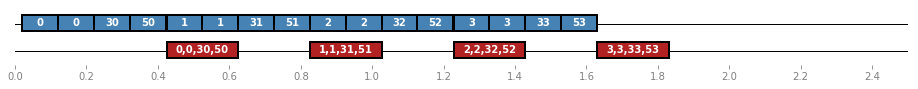

In [34]:
tmp_data_list = [
                [0, 1, 2, 3],
                [10, 11, 12, 13],
                [20, 21, 22, 23],
                [30, 31, 32, 33],
                [40, 41, 42, 43],
                [50, 51, 52, 53],
                [60, 61, 62, 63],
                [70, 71, 72, 73],
                [80, 81, 82, 83],
                [90, 91, 92, 93],
               ]

my_batch_size = 4
my_num_workers = 2
dataset_tmp = MyIterableDatasetV7.split_datasets(tmp_data_list, batch_size = my_batch_size, max_workers=1)
loader = multiStreamDataLoader(dataset_tmp)
plot_timings(loader, model_time=0.2, n_batches = my_batch_size)

The order of the data being returned is correct, however, we still have some waiting time for the model. To rectify this, here is an example which uses two workers, where each worker is processing half of each batch. We also increase the `n_batches` returned to illustrate processing of multiple sequences.

[***] iterable dataset with 2 workers


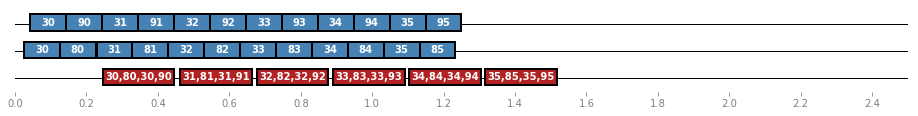

In [39]:
my_data_list = [
    [10, 11, 12, 13, 14, 15],
    [20, 21, 22, 23, 24, 25],
    [30, 31, 32, 33, 34, 35],
    [40, 41, 42, 43, 44, 45],
    [50, 51, 52, 53, 54, 55],
    [60, 61, 62, 63, 64, 65],
    [70, 71, 72, 73, 74, 75],
    [80, 81, 82, 83, 84, 85],
    [90, 91, 92, 93, 94, 95],
]

my_batch_size = 4
my_num_workers = 2
print ('[***] iterable dataset with %d workers' % my_num_workers)
dataset_tmp = MyIterableDatasetV7.split_datasets(my_data_list, batch_size = my_batch_size, max_workers= my_num_workers)
loader = multiStreamDataLoader(dataset_tmp)
plot_timings(loader, model_time=0.2, n_batches = 6)

Note that as the internal DataLoaders are instantiated in series there is a slight delay in start time for each worker, just as we were seeing previously when a single DataLoader was created. This, in turn, causes a slight delay in returning the very first batch.

Lastly, we will show an example with four workers, each processing a single item in each batch, although in this scenario having two workers is actually sufficient as we can see from the previous plot that DataLoaders are queuing sufficient data to avoid waiting times for the model pass.

[***] iterable dataset with 4 workers


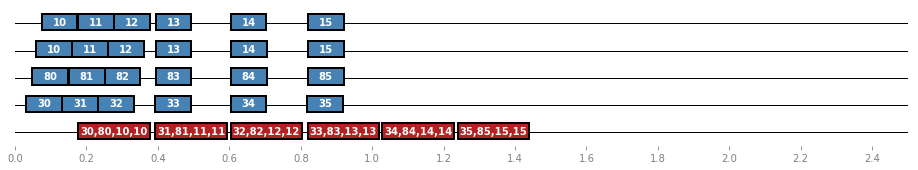

In [42]:
my_data_list = [
    [10, 11, 12, 13, 14, 15],
    [20, 21, 22, 23, 24, 25],
    [30, 31, 32, 33, 34, 35],
    [40, 41, 42, 43, 44, 45],
    [50, 51, 52, 53, 54, 55],
    [60, 61, 62, 63, 64, 65],
    [70, 71, 72, 73, 74, 75],
    [80, 81, 82, 83, 84, 85],
]
my_batch_size = 4
my_num_workers = 4
print ('[***] iterable dataset with %d workers' % my_num_workers)
dataset_tmp = MyIterableDatasetV7.split_datasets(my_data_list, batch_size = my_batch_size, max_workers= my_num_workers)
loader = multiStreamDataLoader(dataset_tmp)
plot_timings(loader, model_time=0.2, n_batches = 6)

## Note:
There is something wrong with the result run in notebook. I would like to show the following result run in my local machine, 

<img src="../files/fig-para-within-batch.png" alt="drawing" width="2500"/>

We again see the ramp-on in timings as each internal DataLoader is created and beyond that, we have full batches being fetched in unison across workers.

One final point which should be emphasised is that `parallelism within batches` relies heavily on balanced loads as each batch is only as fast as its slowest worker. This should not be an issue in the streaming scenario as each batch is processing inputs of constant size, but we should be wary of operations that have an irregular overhead. For example, unzipping or downloading an entire file before feeding it into a generator will have a high cost for specific batches. The effects of which are multiplied when working with multiple streams. In these scenarios, incremental unzipping or iterating over a streaming response should be preferred where possible.

Hopefully, these examples will help you on your way to building your own streaming dataset in PyTorch!

Uploaded the modified code at https://gist.github.com/ccj5351/67e6392200dd9ddcf6f838d326392618.